In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns

from SE.snowflake import _get_DF

In [2]:
!pwd

/Users/philippk/Dropbox/se_projects/DATA_PIPELINES/data_engineering/experts_transaction_matching/notebooks


In [3]:
files = Path('./data/candidates_georef_v4').glob('*.parquet')

In [4]:
df = pd.concat([pd.read_parquet(str(f)) for f in files])

In [5]:
df.shape

(1075314, 40)

In [6]:
df['trxn_id'].nunique()

5908

In [7]:
df['matched'] = df['sale_id'] == df['correct_sale_id']

In [8]:
df['matched'].mean()

0.003239983855878376

In [9]:
df['matched'].mean()

0.003239983855878376

In [10]:
correct_cnt = (df['sale_id'] == df['correct_sale_id']).sum()
matched_cnt = df['correct_sale_id'].nunique()

print(f"For {matched_cnt:,d} Actually Matched Transactions, only {correct_cnt:,d} ({correct_cnt/matched_cnt:,.1%}) are in candidate pools")

For 3,646 Actually Matched Transactions, only 3,484 (95.6%) are in candidate pools


In [12]:
mask = df.groupby('correct_sale_id')['matched'].agg('any')

In [19]:
mask[~mask].index.nunique()

172

In [102]:
# mask

In [20]:
NONMATCHED = set((int(el) for el in mask[~mask].index if el > 0))

In [22]:
# NONMATCHED

## Retreive Unmatched

In [23]:
with open('./unmatched.sql', 'r') as f:
    q = f.read()

In [24]:
unmatched = _get_DF(q).set_index('trxn_id')

/Users/philippk/opt/anaconda3/envs/py37/lib/python3.7/site-packages/snowflake/connector/options.py:99: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [25]:
unmatched['correct_sale_id'].value_counts().head(5)

1566913.0    2
1655975.0    2
1512872.0    2
1618614.0    2
1550112.0    2
Name: correct_sale_id, dtype: int64

In [26]:
m = unmatched['correct_sale_id'].value_counts()

In [27]:
list((int(el) for el in m[(m > 1)].index))

[1566913,
 1655975,
 1512872,
 1618614,
 1550112,
 1621731,
 1663510,
 1506663,
 1624596,
 1608026,
 1558640,
 1631535,
 1471865]

In [28]:
# NONMATCHED

In [29]:
mask = unmatched['correct_sale_id'].isin(NONMATCHED)
unmatched[mask].shape

(171, 40)

In [30]:
unmatched = unmatched[mask]

In [32]:
# unmatched[unmatched.correct_sale_id == 1471865.0]

In [33]:
filter_params = dict(
    price_lim=(-0.1, 0.55),
    day_lim=(-45, 45),
    distance=250
)

In [34]:
## WHy didn't get into Pool?
# unmatched

In [35]:
# unmatched[['spatial', 'days', 'price_pct_diff']]

In [36]:
violations = pd.DataFrame({
    'distance_v': (unmatched['spatial'] > filter_params['distance']),
    'days_v': (~unmatched['days'].between(filter_params['day_lim'][0], filter_params['day_lim'][1])),
    'price_v': (~unmatched['price_pct_diff'].between(filter_params['price_lim'][0], filter_params['price_lim'][1]))           
}, index=unmatched.index)

In [37]:
violations #[~violations.any(axis=1)].head(10)

,distance_v,days_v,price_v
trxn_id,,,
44,False,True,False
65,False,True,False
70,False,True,False
102,False,True,False
111,False,True,False
...,...,...,...
7236,False,True,True
7304,False,True,False
7342,False,True,True


In [38]:
violations.sum()

distance_v     15
days_v        158
price_v        45
dtype: int64

<AxesSubplot:xlabel='spatial', ylabel='Count'>

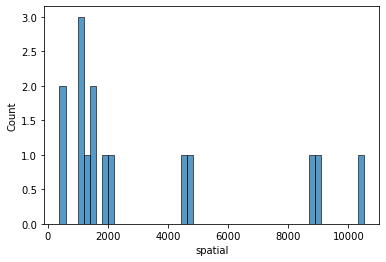

In [39]:
sns.histplot(unmatched.loc[violations['distance_v']], x='spatial', bins=50)

<AxesSubplot:xlabel='days', ylabel='Count'>

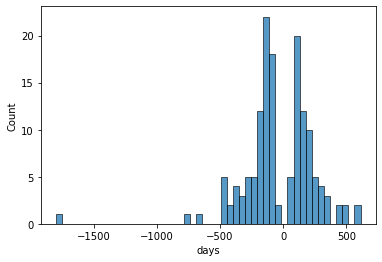

In [40]:
sns.histplot(unmatched.loc[violations['days_v']], x='days', bins=50)

In [41]:
unmatched.loc[violations['days_v'], 'days'].between(45, 90).mean()

0.0379746835443038

In [42]:
unmatched.loc[violations['days_v'], 'days'].between(-90, -45).mean()

0.012658227848101266

<AxesSubplot:xlabel='price_pct_diff', ylabel='Count'>

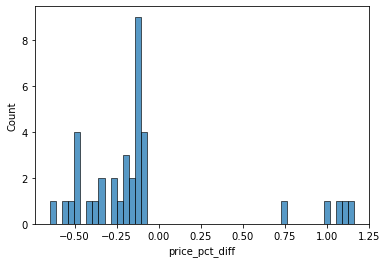

In [43]:
sns.histplot(unmatched.loc[violations['price_v']], x='price_pct_diff', bins=50)

In [44]:
unmatched.loc[violations['price_v'], 'price_pct_diff'].between(-0.25, -0.1).mean()

0.4444444444444444

In [45]:
set(df.columns) - set(unmatched.columns)

{'matched', 'trxn_id'}

In [46]:
set(unmatched.columns) - set(df.columns)

{'status'}

In [47]:
unmatched.to_parquet('./data/candidates_georef_v4/unmatched.parquet')